In [68]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [69]:
import numpy as np
import pandas as pd

In [70]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [71]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [72]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [73]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/bc/13d6601d6mnf1qprjds3gxzc0000gn/T/ipykernel_5914/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [74]:
# We can view all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [75]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [76]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [77]:
# Find the most recent date in the data set.
# Query the most recent date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Print the most recent date
print(f"The most recent date in the data set is {most_recent_date}.")


The most recent date in the data set is 2017-08-23.


In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date one year from the last date in data set.
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()

# Calculate the date one year from the last date in data set.
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"Precipitation"})
# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

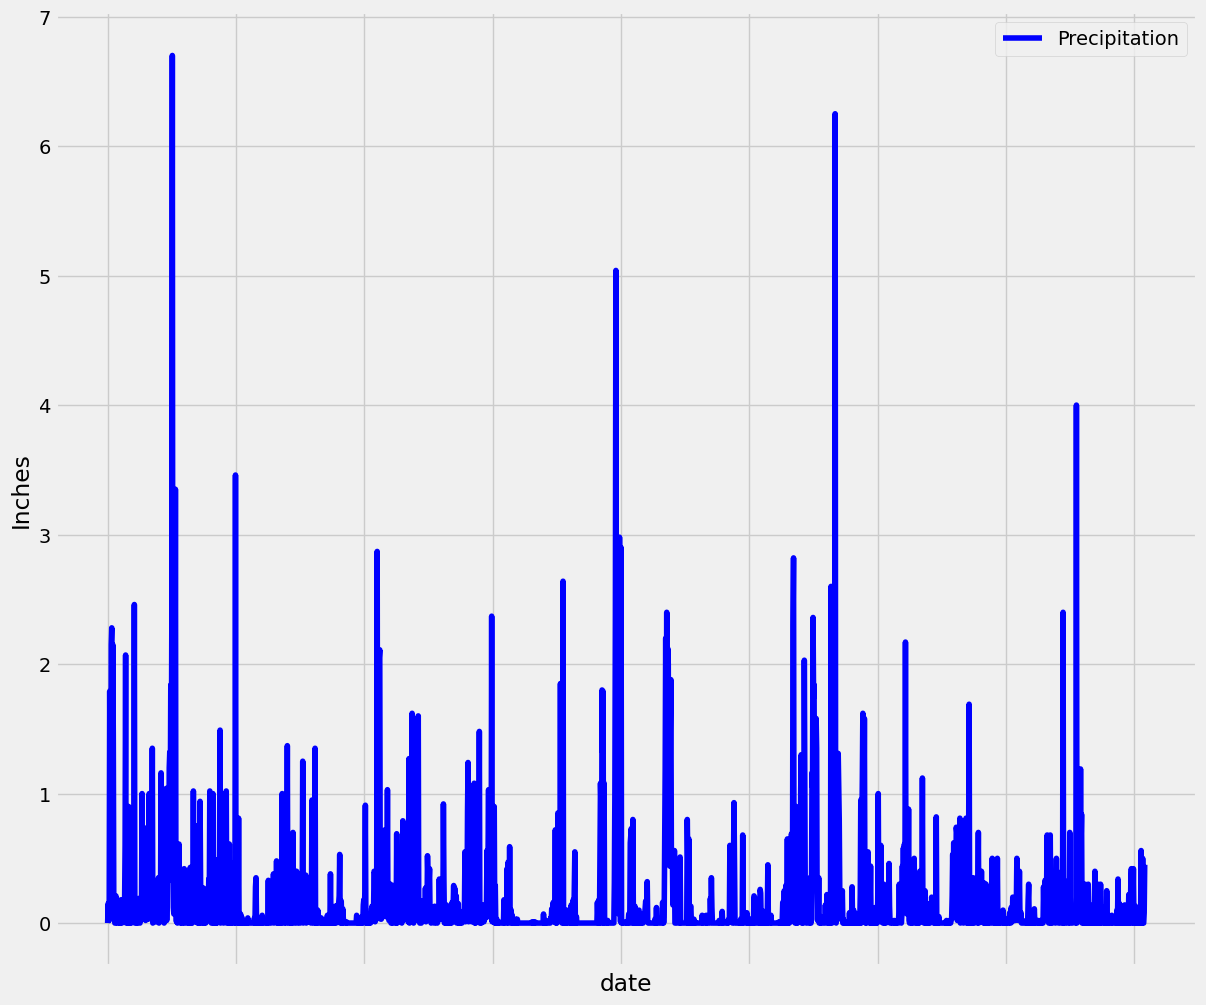

In [84]:

# Use Pandas Plotting with Matplotlib to plot the data
ax=df_results.plot(color='b',figsize=(12,10),legend=True,grid=True)
#Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.ylabel("Inches")
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
#Finding columns and datatype
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Station Analysis

In [48]:
# Design a query to show how many stations are available in this dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [86]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment_join[0][0]).all()
results_temp


[(54.0, 85.0, 71.66378066378067)]

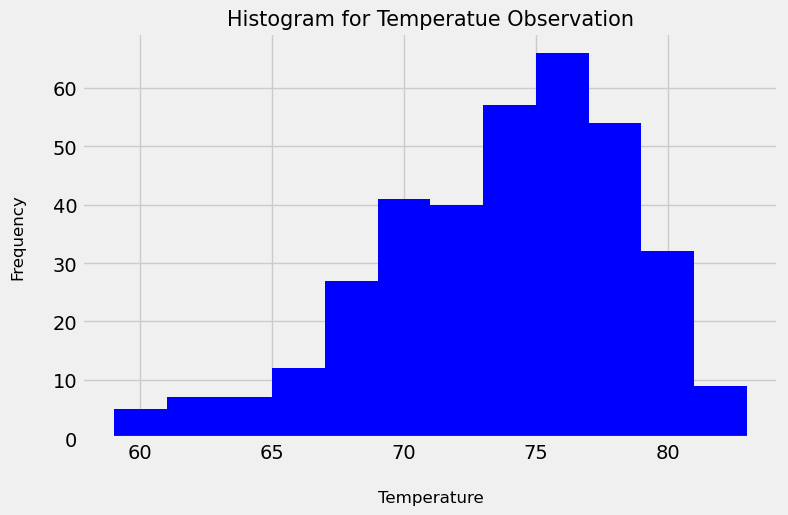

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram 

results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(Measurement.tobs).\
             filter(Measurement.station==station_Measurment_join[0][0]).\
             filter(Measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Remove title
hist.set_title("Histogram for Temperatue Observation",weight='light', size=15)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='light', size=12)
hist.set_xlabel("Temperature", labelpad=20, weight='light', size=12)

plt.show()

## Temperature Analysis II

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year=year_back.year
start_date=str(prev_year)+'-02-28'
end_date=str(prev_year)+'-03-05'
Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_error=Temp_holiday[0][2]-Temp_holiday[0][0]

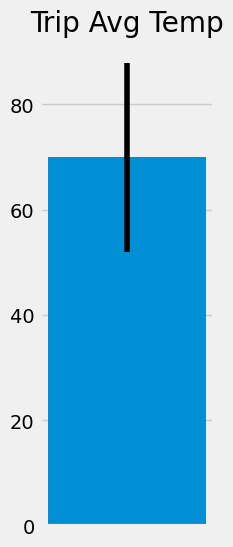

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday[0][1],yerr=Temp_holiday_error)
#Removing xticks
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_Measurment_join=session.query(*sel,func.sum(Measurement.prcp)).\
                       group_by(Measurement.station).\
                       order_by(Measurement.station ).\
                       filter(Measurement.date>=start_date).\
                       filter(Measurement.date<=end_date).\
                       filter(Measurement.station==Station.station).all()
                        
station_Measurment_join

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12000000000000001),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.01),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.33)]

## Optional Challenge Assignment

## Daily Rainfall Average

In [56]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [57]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
current_year=latest_date.year
start_date=str(current_year)+'-02-28'
end_date=str(current_year)+'-03-05'
# Use the start and end date to create a range of dates
results=session.query(Measurement.date).order_by(Measurement.date.asc()).\
       filter(Measurement.date>=start_date).\
       filter(Measurement.date<=end_date).distinct()
# Stip off the year and save a list of %m-%d strings
date_trip_df=pd.DataFrame(results.all())
normal=date_trip_df['date'].str.slice(start=5)
date_trip_df = date_trip_df.set_index('date') 
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms=[]
for month_date in range(len(normal)):
    daily_value=daily_normals(normal[month_date])[0]
    daily_norms.append(tuple(daily_value))
daily_norms

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data_df=pd.DataFrame(daily_norms)

date_trip_df['tmin']=data_df[0].tolist()
date_trip_df['tavg']=data_df[1].tolist()
date_trip_df['tmax']=data_df[2].tolist()
date_trip_df

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


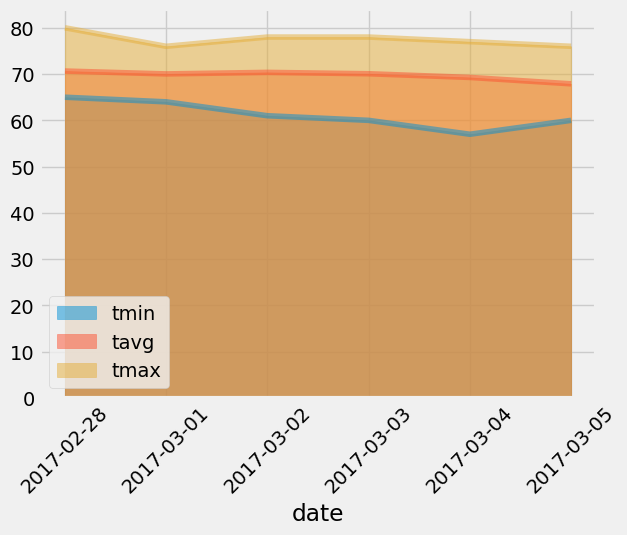

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
ax = date_trip_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()

## Temperature Analysis I

In [60]:
hawaii_measurements=pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_stations=pd.read_csv('Resources/hawaii_stations.csv')
hawaii_measurements.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [61]:
#Finding average temperature by grouping by 
avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()

/var/folders/bc/13d6601d6mnf1qprjds3gxzc0000gn/T/ipykernel_5914/1986571863.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
/var/folders/bc/13d6601d6mnf1qprjds3gxzc0000gn/T/ipykernel_5914/1986571863.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()


In [62]:
#Display output
avg_june_temp['tobs']

station
USC00511918    74.139394
USC00513117    74.050847
USC00514830    76.005376
USC00516128    71.937220
USC00517948    76.655405
USC00518838    73.394737
USC00519281    73.271186
USC00519397    77.559322
USC00519523    76.668103
Name: tobs, dtype: float64

In [63]:
#Display output
avg_dec_temp['tobs']

station
USC00511918    69.684211
USC00513117    71.069444
USC00514830    73.224719
USC00516128    69.291262
USC00517948    71.834862
USC00518838    72.421053
USC00519281    69.903226
USC00519397    71.109524
USC00519523    72.433333
Name: tobs, dtype: float64

In [64]:
 # Calculate Independent (Two Sample) T-Test
import scipy.stats as stats
stats.ttest_ind(avg_june_temp['tobs'], avg_dec_temp['tobs'], equal_var=False)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

## Observation
#### I'm using unpaired t test as the data is distinct i.e. one for month of June and other for Dec. pvalue less than 5% i.e. 0.05 we are rejecting null hypothesis and records are statistically significant as pvalue is apprx- 0.00036.